In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'default',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
request = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as scores
FROM {db}.ldn_listings
WHERE toFloat32OrNull(review_scores_rating) is not null
ORDER BY id asc
LIMIT 1000
'''
request_test = ph.read_clickhouse(query=request, connection=connection_default)

In [4]:
# result = request_test.groupby('room_type')['price'].quantile(0.75)

In [5]:
# result

In [6]:
request_test = request_test  \
    .groupby('room_type', as_index=False) \
    .agg({'price': 'mean', 'scores': 'mean'})

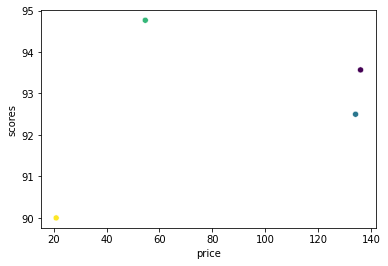

In [7]:
sns.scatterplot(data=request_test, x='price', y='scores')

In [8]:
request_test

,room_type,price,scores
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


In [9]:
exp = '''
select
    distinct host_id,
    host_verifications
from {db}.ldn_listings
where experiences_offered != 'none'
'''
exp_work = ph.read_clickhouse(query=exp, connection=connection_default)

In [10]:
exp_work['host_verifications'] = exp_work['host_verifications'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))

In [11]:
exp_work['host_verifications'].explode('host_verifications').value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [12]:
exp_count = '''
select
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) as experiences_count 
from {db}.ldn_listings
where experiences_offered != 'none'
group by 
    neighbourhood_cleansed,
    experiences_offered
order by experiences_count desc
limit 100
'''
exp_work_two = ph.read_clickhouse(query=exp_count, connection=connection_default)

In [13]:
exp_work_pivot = exp_work_two.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

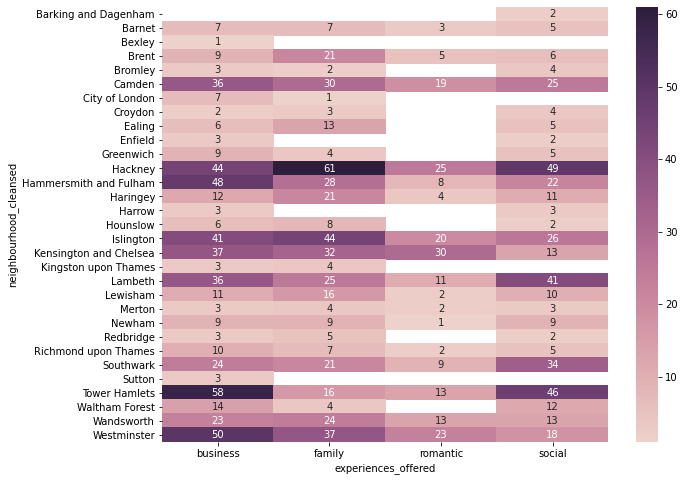

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=exp_work_pivot, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))